In [239]:
from glob import glob
import pandas as pd
import json
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

In [ ]:
fm.fontManager.addfont("./style/Lato/Lato-Regular.ttf")
plt.rcParams["font.family"] = "Lato"
plt.style.use("style/lato_modern.mplstyle")

# Auswertung der Ergebnisse

Auf dem Zukunftskongress 2025 haben wir interessierte Personen das Spiel Postkorb Panic spielen lassen. Die Spielenden waren Personen, die mit dem öffentlichen Sektor zu tun haben. Dazu zählen Personen aus dem öffentlichen Sektor und Personen, die Auftragnehmer für den öffentlichen Sektor sind.

Dieses Notebook macht eine Auswertung der Ergebnisse.

In [128]:
files = glob("../results/*.json")

In [129]:
files

['../results/Postkorb-Panic_Ergebnisse.json']

In [130]:
feedback = []

for file in files:
    with open(file) as f:
        feedback.extend(json.load(f))

In [131]:
feedback_data = []

for game_id, f in enumerate(feedback):
    for question_id, result in enumerate(f["gameResults"]):
        d = {col: val for col, val in f.items() if col != "gameResults"}
        d["game_id"] = game_id
        d["question_pos"] = question_id
        for col, value in result.items():
            d[col] = value
        feedback_data.append(d)

In [132]:
feedback_data = pd.DataFrame(feedback_data)

# Wie viele Spiele wurden gespielt?

In [146]:
feedback_data["game_id"].nunique()

80

In [148]:
feedback_data.drop_duplicates("game_id")["aiMode"].value_counts()

aiMode
True     55
False    25
Name: count, dtype: int64

# Alle E-Mail-Adressen mit Namen auslesen und ausgeben

In [35]:
feedback_data[feedback_data["email"] != ""][["name", "email"]].drop_duplicates().to_csv(
    "../results/emails.csv", index=False
)

# Auswertung

## Geschwindigkeit insgesamt mit und ohne KI

<Axes: >

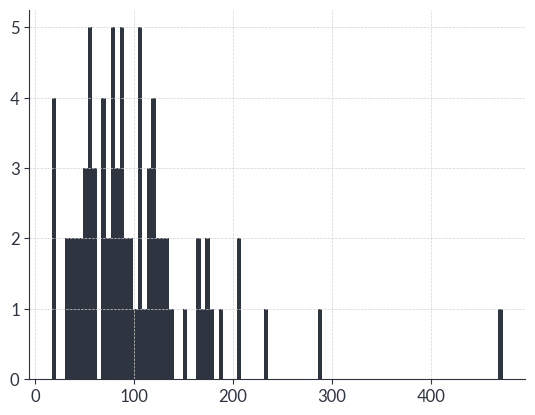

In [172]:
feedback_data.drop_duplicates("game_id")["totalTime"].hist(bins=100)

In [36]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["totalTime"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,120.828000,121.2,43.2,206.6
True,92.978182,79.0,16.8,473.1


In [185]:
# Example input: replace with your real data
ai_correct = list(
    feedback_data[feedback_data["aiMode"]].drop_duplicates("game_id")["totalTime"]
)
no_ai_correct = list(
    feedback_data[~feedback_data["aiMode"]].drop_duplicates("game_id")["totalTime"]
)

# Use Mann–Whitney U test (non-parametric)
u_stat, p_value = stats.mannwhitneyu(ai_correct, no_ai_correct, alternative="less")

print(f"P-value: {p_value * 100}%")

alpha = 0.01
if p_value < alpha:
    print("Result: Significant difference — AI-Mode is faster than Non-AI-Mode.")
else:
    print("Result: No significant difference found.")

P-value: 0.050012654041163646%
Result: Significant difference — AI-Mode is faster than Non-AI-Mode.


In [ ]:
def violinplot(
    data,
    col="correct",
    ylabel="Dauer pro Frage in Sekunden",
    filepath="bilder/test.pdf",
):
    with_ai = data[data["aiMode"]][col]
    without_ai = data[~data["aiMode"]][col]

    plt.violinplot([without_ai], positions=[0], showmedians=True, showextrema=False)
    a = plt.violinplot([with_ai], positions=[1], showmedians=True, showextrema=False)
    for pc in a["bodies"]:  # type: ignore
        pc.set_color("#FFE600")
    a["cmedians"].set_colors("black")  # type: ignore

    plt.ylabel(ylabel)
    plt.xticks([0, 1], labels=["Ohne KI", "Mit KI"])
    plt.savefig(filepath)
    plt.show()

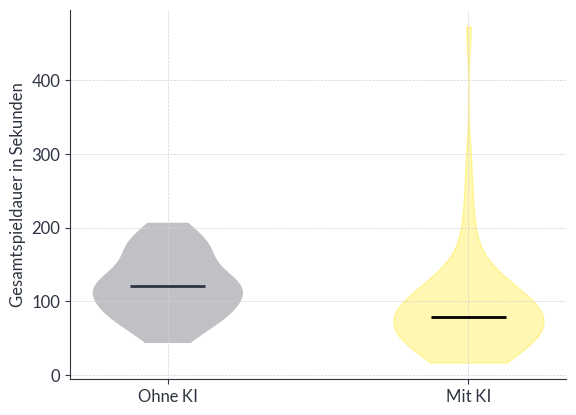

In [ ]:
games = feedback_data.drop_duplicates("game_id")
violinplot(
    games,
    col="totalTime",
    ylabel="Gesamtspieldauer in Sekunden",
    filepath="./bilder/Gesamtzeit.pdf",
)

## Geschwindigkeit pro Frage mit und ohne KI

In [68]:
feedback_data.groupby("aiMode")["responseTime"].agg(["mean", "median", "min", "max"])

,mean,median,min,max
aiMode,,,,
False,11.188916,9.6725,0.265,46.897
True,8.378587,5.8810,0.063,98.865


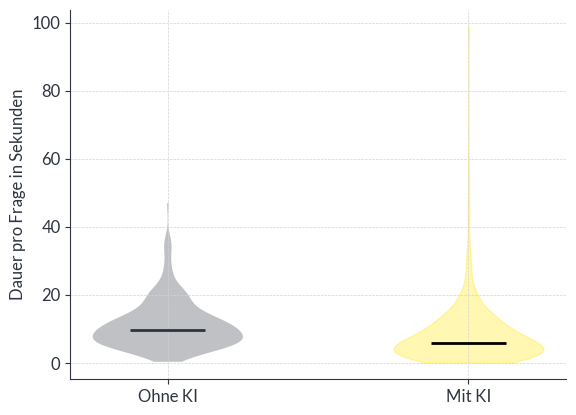

In [ ]:
violinplot(
    feedback_data,
    col="responseTime",
    ylabel="Dauer pro Frage in Sekunden",
    filepath="./bilder/Fragezeit.pdf",
)

# Anzahl der korrekten Antworten mit und ohne KI

In [79]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["correct"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,7.080000,7.0,4,9
True,8.836364,9.0,5,10


In [ ]:
# Example input: replace with your real data
ai_correct = list(
    feedback_data[feedback_data["aiMode"]].drop_duplicates("game_id")["correct"]
)
no_ai_correct = list(
    feedback_data[~feedback_data["aiMode"]].drop_duplicates("game_id")["correct"]
)

# Use Mann–Whitney U test (non-parametric)
u_stat, p_value = stats.mannwhitneyu(ai_correct, no_ai_correct, alternative="greater")

print(f"P-value: {p_value * 100}%")

alpha = 0.01
if p_value < alpha:
    print("Result: Significant difference — AI-Mode is more correct Non-AI-Mode.")
else:
    print("Result: No significant difference found.")

P-value: 8.87594516586777e-06%
Result: Significant difference — AI-Mode is more correct Non-AI-Mode.


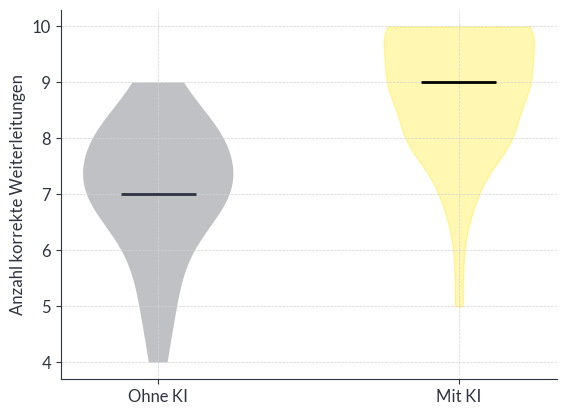

In [176]:
violinplot(
    feedback_data.drop_duplicates("game_id"),
    col="correct",
    ylabel="Anzahl korrekte Weiterleitungen",
    filepath="./bilder/KorrekteAntworten.pdf",
)

# Scores mit und ohne KI

In [ ]:
feedback_data.groupby("game_id").agg({"aiMode": "first", "score": "sum"}).groupby(
    "aiMode"
)["score"].agg(["mean", "median", "min", "max"])

,mean,median,min,max
aiMode,,,,
False,27.324000,25.3,5.6,71.5
True,54.510909,53.6,1.9,100.0


In [ ]:
scores = feedback_data.groupby("game_id").agg({"aiMode": "first", "score": "sum"})
# Example input: replace with your real data
ai_correct = list(scores[scores["aiMode"]]["score"])
no_ai_correct = list(scores[~scores["aiMode"]]["score"])

# Use Mann–Whitney U test (non-parametric)
u_stat, p_value = stats.mannwhitneyu(ai_correct, no_ai_correct, alternative="greater")

print(f"P-value: {p_value * 100}%")

alpha = 0.01
if p_value < alpha:
    print(
        "Result: Significant difference — AI-Mode has higher scores than Non-AI-Mode."
    )
else:
    print("Result: No significant difference found.")

P-value: 0.0037458584250488437%
Result: Significant difference — AI-Mode has higher scores than Non-AI-Mode.


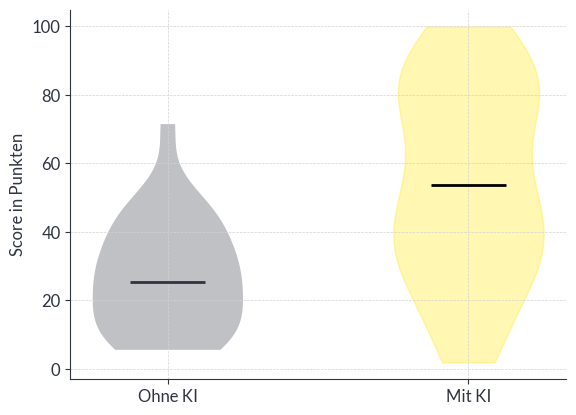

In [ ]:
scores = feedback_data.groupby("game_id").agg(
    {"aiMode": "first", "score": "sum", "responseTime": "sum", "correct": "first"}
)
violinplot(
    scores, col="score", ylabel="Score in Punkten", filepath="./bilder/Scores.pdf"
)

In [271]:
# Spiele mit schlechten Scores
scores[(scores["score"] < 20) & (scores["aiMode"])]

,aiMode,score,responseTime,correct
game_id,,,,
6,True,1.9,467.345,9
16,True,15.8,161.452,8
19,True,9.6,226.685,7
20,True,5.2,156.347,6
22,True,14.7,126.956,10
34,True,12.5,197.683,10
51,True,4.1,280.912,9


## Werden Teilnehmende mit der Zeit schneller? (KI vs. ohne KI)

In [ ]:
question_times_with_ai = [
    np.array(
        feedback_data[(feedback_data["aiMode"]) & (feedback_data["question_pos"] == i)][
            "responseTime"
        ]
    )
    for i in range(10)
]
question_times_without_ai = [
    np.array(
        feedback_data[
            (~feedback_data["aiMode"]) & (feedback_data["question_pos"] == i)
        ]["responseTime"]
    )
    for i in range(10)
]

In [210]:
stats.friedmanchisquare(*question_times_without_ai)

FriedmanchisquareResult(statistic=np.float64(17.491636363636417), pvalue=np.float64(0.041551068656706214))

In [211]:
stats.friedmanchisquare(*question_times_with_ai)

FriedmanchisquareResult(statistic=np.float64(26.719184123484116), pvalue=np.float64(0.0015564170150032415))

In [228]:
with_ai = True
antwortzeiten = []
for game_id in list(
    feedback_data[feedback_data["aiMode"] == with_ai]["game_id"].unique()
):
    d = []
    for q_pos in range(10):
        d.append(
            feedback_data[
                (feedback_data["question_pos"] == q_pos)
                & (feedback_data["game_id"] == game_id)
            ]["responseTime"].item()
        )

    antwortzeiten.append(d)

In [229]:
# Speichere die Steigungen und p-Werte
steigungen = []
p_werte = []

for spiel in antwortzeiten:
    slope, intercept, r_value, p_value, std_err = stats.linregress(range(10), spiel)
    steigungen.append(slope)
    p_werte.append(p_value)

# Ergebnisse anzeigen
for i, (s, p) in enumerate(zip(steigungen, p_werte)):
    print(f"Spiel {i + 1}: Steigung = {s:.3f}, p-Wert = {p:.4f}")

# Gesamtanalyse: Mittelwert der Steigungen + Signifikanztest gegen 0
t_stat, p_overall = stats.ttest_1samp(steigungen, 0)

print(f"\n⏬ Durchschnittliche Steigung: {np.mean(steigungen):.3f}")
print(f"📊 t-Test gegen 0: t = {t_stat:.3f}, p = {p_overall:.4f}")

Spiel 1: Steigung = -0.501, p-Wert = 0.0605
Spiel 2: Steigung = -0.120, p-Wert = 0.3769
Spiel 3: Steigung = -1.314, p-Wert = 0.0033
Spiel 4: Steigung = -4.476, p-Wert = 0.1827
Spiel 5: Steigung = 0.462, p-Wert = 0.0660
Spiel 6: Steigung = 0.532, p-Wert = 0.0459
Spiel 7: Steigung = -2.406, p-Wert = 0.0022
Spiel 8: Steigung = -0.004, p-Wert = 0.9931
Spiel 9: Steigung = 0.350, p-Wert = 0.3712
Spiel 10: Steigung = -0.619, p-Wert = 0.1158
Spiel 11: Steigung = -1.499, p-Wert = 0.0545
Spiel 12: Steigung = -0.065, p-Wert = 0.9473
Spiel 13: Steigung = 2.008, p-Wert = 0.0749
Spiel 14: Steigung = -0.427, p-Wert = 0.4464
Spiel 15: Steigung = -0.262, p-Wert = 0.3581
Spiel 16: Steigung = 0.555, p-Wert = 0.0023
Spiel 17: Steigung = -0.087, p-Wert = 0.1091
Spiel 18: Steigung = 0.805, p-Wert = 0.0008
Spiel 19: Steigung = -0.936, p-Wert = 0.0065
Spiel 20: Steigung = 0.396, p-Wert = 0.2322
Spiel 21: Steigung = 0.044, p-Wert = 0.8677
Spiel 22: Steigung = 0.352, p-Wert = 0.5441
Spiel 23: Steigung = -0.381,

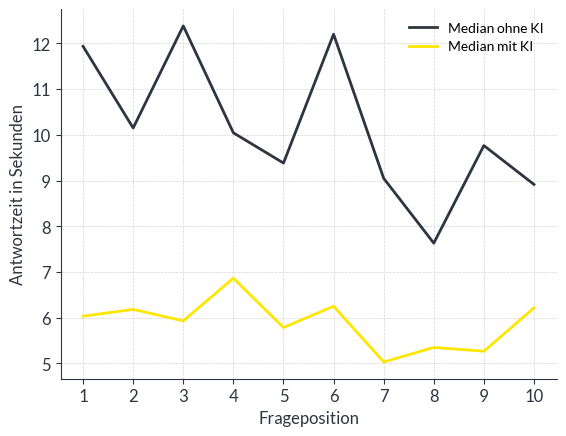

In [ ]:
# for game_id in feedback_data["game_id"].unique():
#     game = feedback_data[feedback_data["game_id"] == game_id]
#     color = "#FFE600" if game["aiMode"].all() else "#2e3440"
#     plt.plot(game["question_pos"], game["responseTime"], color=color, alpha=0.1)

mean_with_ai = (
    feedback_data[feedback_data["aiMode"]]
    .groupby("question_pos")["responseTime"]
    .median()
)
mean_without_ai = (
    feedback_data[~feedback_data["aiMode"]]
    .groupby("question_pos")["responseTime"]
    .median()
)
plt.plot(mean_without_ai, label="Median ohne KI")
plt.plot(mean_with_ai, color="#FFE600", label="Median mit KI")

plt.xlabel("Frageposition")
plt.ylabel("Antwortzeit in Sekunden")
plt.xticks(range(10), labels=range(1, 11))
plt.legend()

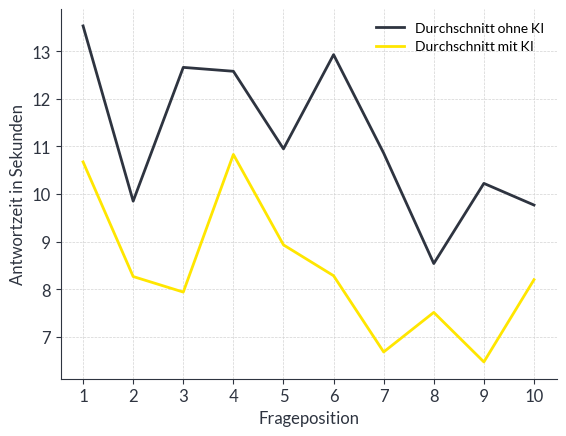

In [223]:
# for game_id in feedback_data["game_id"].unique():
#     game = feedback_data[feedback_data["game_id"] == game_id]
#     color = "#FFE600" if game["aiMode"].all() else "#2e3440"
#     plt.plot(game["question_pos"], game["responseTime"], color=color, alpha=0.1)

mean_with_ai = (
    feedback_data[feedback_data["aiMode"]]
    .groupby("question_pos")["responseTime"]
    .mean()
)
mean_without_ai = (
    feedback_data[~feedback_data["aiMode"]]
    .groupby("question_pos")["responseTime"]
    .mean()
)
plt.plot(mean_without_ai, label="Durchschnitt ohne KI")
plt.plot(mean_with_ai, color="#FFE600", label="Durchschnitt mit KI")

plt.xlabel("Frageposition")
plt.ylabel("Antwortzeit in Sekunden")
plt.xticks(range(10), labels=range(1, 11))
plt.legend()
plt.savefig("./bilder/Frageposition.pdf")
plt.show()

In [ ]:
feedback_data[~feedback_data["aiMode"]].groupby("question_pos")[
    "responseTime"
].median().plot(
    title="Durchschn. Antwortzeit pro Frage an Position (ohne KI)",
    xlabel="Frageposition",
    ylabel="Antwortzeit in Sekunden",
)

# Welche Kategorie wird wie oft getippt?

In [241]:
possible_depts = [
    "Personalabteilung",
    "Finanzabteilung",
    "Rechtsabteilung",
    "Leitungsebene",
    "Kundenservice",
]

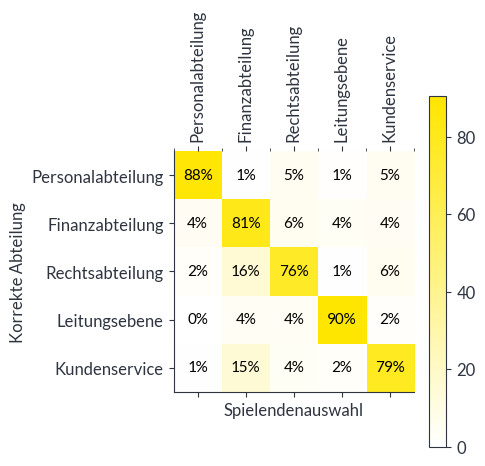

In [282]:
incorrect_feedback = feedback_data[["correctDept", "playerChoice"]]

conf_matrix = confusion_matrix(
    incorrect_feedback["correctDept"], incorrect_feedback["playerChoice"]
)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
)

conf_matrix_df = pd.DataFrame(
    conf_matrix_normalized, index=possible_depts, columns=possible_depts
)

# Werte und Labels extrahieren
matrix = conf_matrix_df.values
labels = conf_matrix_df.columns

fig, ax = plt.subplots(figsize=(5, 5))

# Farbverlauf von Weiß zu #FFE600
custom_cmap = LinearSegmentedColormap.from_list(
    "white_to_yellow", ["#FFFFFF", "#FFE600"]
)
cax = ax.matshow(matrix, cmap=custom_cmap)

# Colorbar
fig.colorbar(cax)

# Achsentitel
ax.set_xlabel("Spielendenauswahl", fontsize=12)
ax.set_ylabel("Korrekte Abteilung", fontsize=12)

# Achsenticks und -labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="center", va="bottom")
ax.set_yticklabels(labels)

# Gitterlinien entfernen
ax.set_xticks(np.arange(len(labels) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(labels) + 1) - 0.5, minor=True)
ax.grid(False)  # Hauptgrid aus
ax.tick_params(which="minor", bottom=False, left=False)  # Minorticks aus

# Zellwerte eintragen
for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, f"{val:.0f}%", fontsize=11, va="center", ha="center", color="black")

plt.tight_layout()

# PDF exportieren
plt.savefig("./bilder/Konfusionsmatrix.pdf")
plt.show()

## Machen Menschen ähnliche Fehler wie die KI?

Da, wo Menschen ohne KI spielen und die KI einen Fehler machen würden; wie viele Menschen machen den gleichen Fehler?

Im Verhältnis dazu: Wie viele Fehler machen die Menschen generell?

In [ ]:
# Bei Emails, die die KI falsch zuordnen würde; wie richtig haben Menschen die Mail zugewiesen?
feedback_data[
    (~feedback_data["aiMode"])
    & (feedback_data["aiSuggestion"] != feedback_data["correctDept"])
]["isCorrect"].value_counts(normalize=True)

isCorrect
False    0.615385
True     0.384615
Name: proportion, dtype: float64

In [ ]:
# Bei Emails, die die KI richtig zuordnen würde; wie richtig haben Menschen die Mail zugewiesen?
feedback_data[
    (~feedback_data["aiMode"])
    & (feedback_data["aiSuggestion"] == feedback_data["correctDept"])
]["isCorrect"].value_counts(normalize=True)

isCorrect
True     0.725738
False    0.274262
Name: proportion, dtype: float64

In [ ]:
feedback_data[(~feedback_data["isCorrect"]) & (~feedback_data["aiMode"])][
    ["text", "correctDept", "playerChoice", "aiSuggestion"]
]

,text,correctDept,playerChoice,aiSuggestion
12,"Sehr geehrte Damen und Herren,\n\nich wende mi...",Rechtsabteilung,Leitungsebene,Rechtsabteilung
14,"Guten Tag,\n\nich hoffe, dass Sie eine gute Wo...",Personalabteilung,Leitungsebene,Personalabteilung
54,"Hallo,\n\nich hoffe Sie haben genau so schönes...",Leitungsebene,Kundenservice,Kundenservice
63,"Sehr geehrte Damen und Herren,\n\nich hoffe, d...",Kundenservice,Rechtsabteilung,Kundenservice
123,"Sehr geehrte Damen und Herren,\n\nIch schreib ...",Personalabteilung,Rechtsabteilung,Personalabteilung
...,...,...,...,...
754,"Guten Tag,\n\nich hoffe, Sie hatten eine angen...",Kundenservice,Leitungsebene,Kundenservice
755,"Sehr geehrte Damen und Herren,\n\nich schreibe...",Rechtsabteilung,Finanzabteilung,Rechtsabteilung
766,"Sehr geehrte Damen und Herren,\n\nich hoffe, d...",Leitungsebene,Kundenservice,Leitungsebene
767,"Hey Leute,\n\nmuss das hier wohl jetzt doch ma...",Rechtsabteilung,Kundenservice,Kundenservice
